# Adapting Problem Session 8 to our DST project


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set_style("whitegrid")


In [3]:
finance = pd.read_csv('finance1970-2018.csv')

In [4]:
finance.sample(4)


,Unnamed: 0,index,ticker,open,close,adj_close,low,high,volume,date,date_time
376080,376080,20519327,COLB,25.820000,25.730000,20.175480,25.629999,25.889999,6500,2005-10-07,2005-10-07
1694986,1694986,1709532,WNEB,6.506409,6.628309,4.358642,6.506409,6.649642,31800,2004-08-24,2004-08-24
65929,65929,18247853,ASRV,4.166667,4.166667,1.230702,4.000000,4.166667,44400,1989-06-29,1989-06-29
1618580,1618580,3758137,UFCS,20.059999,20.230000,16.175444,19.719999,20.420000,51000,2011-12-05,2011-12-05


In [6]:
finance_ticker = pd.read_csv('finance_stocks.csv')

In [8]:
finance_ticker.sample(4)

,Unnamed: 0,ticker,exchange,name,sector,industry
728,3650,BMO,NYSE,BANK OF MONTREAL,FINANCE,COMMERCIAL BANKS
380,1786,LCAHW,NASDAQ,"LANDCADIA HOLDINGS, INC.",FINANCE,BUSINESS SERVICES
526,2451,PRAA,NASDAQ,"PRA GROUP, INC.",FINANCE,FINANCE: CONSUMER SERVICES
855,4901,JLL,NYSE,JONES LANG LASALLE INCORPORATED,FINANCE,REAL ESTATE


In [5]:
def get_stocks(df, df2, stock_code):
    # get prices for a particular stock; this function takes in two data frames where one has the prices
    # the other has the codes
    print(df2[df2['ticker']==stock_code])
    return df[df['ticker']==stock_code].reset_index()

In [9]:
df_WFC=get_stocks(finance, finance_ticker, 'WFC')

      Unnamed: 0 ticker exchange                   name   sector     industry
1012        6350    WFC     NYSE  WELLS FARGO & COMPANY  FINANCE  MAJOR BANKS


In [10]:
df_WFC

,level_0,Unnamed: 0,index,ticker,open,close,adj_close,low,high,volume,date,date_time
0,3086663,3086663,17065605,WFC,0.880208,0.880208,0.002267,0.880208,0.882812,249600,1972-06-01,1972-06-01
1,3086664,3086664,17065615,WFC,0.882812,0.882812,0.002274,0.882812,0.890625,172800,1972-06-02,1972-06-02
2,3086665,3086665,17065628,WFC,0.882812,0.895833,0.002308,0.880208,0.895833,302400,1972-06-05,1972-06-05
3,3086666,3086666,17065639,WFC,0.895833,0.895833,0.002308,0.893229,0.911458,196800,1972-06-06,1972-06-06
4,3086667,3086667,17065649,WFC,0.895833,0.888021,0.002287,0.888021,0.895833,48000,1972-06-07,1972-06-07
...,...,...,...,...,...,...,...,...,...,...,...,...
11650,3098313,3098313,17189905,WFC,58.810001,59.029999,59.029999,58.669998,59.209999,11403400,2018-08-20,2018-08-20
11651,3098314,3098314,17189921,WFC,59.000000,58.959999,58.959999,58.939999,59.529999,17943500,2018-08-21,2018-08-21
11652,3098315,3098315,17189927,WFC,59.040001,59.169998,59.169998,58.830002,59.500000,20829600,2018-08-22,2018-08-22
11653,3098316,3098316,17189943,WFC,59.000000,58.619999,58.619999,58.570000,59.049999,19655600,2018-08-23,2018-08-23


In [37]:
def custom_time_indexing(df, date_column):
    """
    Function to reindex a DataFrame with a custom index that reflects gaps in a time series,
    while keeping the original date column for plotting, without modifying the original DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    date_column (str): Name of the column containing datetime objects.

    Returns:
    pd.DataFrame: A new DataFrame with the custom index reflecting date gaps,
                  while retaining the original dates in a new column.
    list: A list of the original date labels corresponding to valid data rows.
    """
    # Work on a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Ensure the date_column is of datetime type
    df_copy[date_column] = pd.to_datetime(df_copy[date_column])

    # Set the date column as the index
    df_copy.set_index(date_column, inplace=True)

    # Generate the full date range (including missing dates)
    full_range = pd.date_range(start=df_copy.index.min(), end=df_copy.index.max())

    # Reindex the DataFrame to include the full range of dates
    df_reindexed = df_copy.reindex(full_range)

    # Create a custom index that increments by 1, but jumps when there are missing dates
    custom_index = []
    current_index = 1

    for i in range(len(df_reindexed)):
        if i == 0:
            custom_index.append(current_index)
        else:
            # Check if the current date is consecutive to the previous one
            if df_reindexed.index[i] - df_reindexed.index[i-1] > timedelta(days=1):
                # Increase the custom index by the actual day difference
                current_index += (df_reindexed.index[i] - df_reindexed.index[i-1]).days
            else:
                current_index += 1
            custom_index.append(current_index)

    # Assign the custom index to the DataFrame
    df_reindexed['custom_index'] = custom_index

    # Drop the rows where there are missing values
    df_final = df_reindexed.dropna()

    # Add the original date index as a new column and make it a datetime object
    df_final['date_time'] = df_final.index
    df_final['date_time']=df_final['date_time'].apply(lambda day: day.date())

    # Set the new custom index
    df_final.set_index('custom_index', inplace=True)

    # Return the final DataFrame and the valid original dates
    return df_final, df_final['date_time']


In [38]:
df_WFC_reindex = custom_time_indexing(df_WFC,'date_time')[0]

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_96401/3743447978.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date_time'] = df_final.index
/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_96401/3743447978.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date_time']=df_final['date_time'].apply(lambda day: day.date())


In [58]:
metrics = list(df_WFC.columns)

In [59]:
metrics = metrics[4:10]
metrics

['open', 'close', 'adj_close', 'low', 'high', 'volume']

We only want weekends and then to have a column that says whether it's a DST weekend

In [26]:
weekends=pd.read_csv('weekends1970_2018.csv')

In [32]:
weekends.head()

,Unnamed: 0,Fridays,Mondays
0,0,1970-01-02,1970-01-05
1,1,1970-01-09,1970-01-12
2,2,1970-01-16,1970-01-19
3,3,1970-01-23,1970-01-26
4,4,1970-01-30,1970-02-02


In [33]:
# ANOTHER VERY USEFUL function for getting the stock prices of all weekends; need dataframe and metrics

def get_fri_mon_prices(df,fri_metric,mon_metric):
    # metric1,2 = high, low, open, close, volume, etc.
    mon_fri_prices=[]

    for fri,mon in zip(weekends['Fridays'].values, weekends['Mondays'].values): # I stored these as strings
        fri = datetime.strptime(fri, '%Y-%m-%d').date()
        mon = datetime.strptime(mon, '%Y-%m-%d').date()

        if (fri in df['date_time'].values) and (mon in df['date_time'].values):
            print('Have data for both:',fri, mon)
            
            fri_price=df.loc[df['date_time'] == fri, fri_metric].values[0]
            mon_price=df.loc[df['date_time'] == mon, mon_metric].values[0]
            
            mon_fri_prices.append((fri.strftime('%Y-%m-%d'),mon.strftime('%Y-%m-%d'),fri_price,mon_price))

        else:
            print('Missing data for at least one of:', fri, mon) 
    return mon_fri_prices 

In [28]:
# for suppressing what a function prints out as part of debugging
import contextlib
import io

In [40]:
with contextlib.redirect_stdout(io.StringIO()):
    WFC_open= get_fri_mon_prices(df_WFC_reindex,'open','open')

In [44]:
df_WFC_open = pd.DataFrame(WFC_open)

In [47]:
df_WFC_open.columns = ['fri','mon','fri_open','mon_open']

In [49]:
# see just the info
df_WFC_open[['fri_open','mon_open']]

,fri_open,mon_open
0,0.882812,0.882812
1,0.890625,0.895833
2,0.893229,0.895833
3,0.906250,0.914062
4,0.947917,0.958333
...,...,...
2122,56.070000,56.389999
2123,58.380001,58.830002
2124,58.060001,58.580002
2125,57.380001,57.660000


Let's write a function which gets Friday and Monday info for each of the metrics, then puts it all into one large dataframe. We'll eventually need to add columns to say whether it's a DST weekend or not, then use get_dummies to just get a categorical column

##### b.

Create a new column of the `DataFrame` called `y` where `y=1` if `Class=Ürgüp Sivrisi` and `y=0` if `Class=Çerçevelik`.

In [14]:
seeds['y']=1.0*pd.get_dummies(seeds['Class'])['Ürgüp Sivrisi']

seeds

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class,y
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik,0.0
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik,0.0
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik,0.0
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik,0.0
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,79637,1224.710,533.1513,190.4367,80381,318.4289,0.9340,0.9907,0.4888,0.6672,2.7996,0.5973,Ürgüp Sivrisi,1.0
2496,69647,1084.318,462.9416,191.8210,70216,297.7874,0.9101,0.9919,0.6002,0.7444,2.4134,0.6433,Ürgüp Sivrisi,1.0
2497,87994,1210.314,507.2200,222.1872,88702,334.7199,0.8990,0.9920,0.7643,0.7549,2.2828,0.6599,Ürgüp Sivrisi,1.0
2498,80011,1182.947,501.9065,204.7531,80902,319.1758,0.9130,0.9890,0.7374,0.7185,2.4513,0.6359,Ürgüp Sivrisi,1.0


#### 2. Learn about the data

##### a.

These data represent various measurements of pumpkin seeds that come from high quality photos of the seeds. The data was provided as supplementary material to <a href="https://link.springer.com/article/10.1007/s10722-021-01226-0">The use of machine learning methods in classification of pumpkin seeds (Cucurbita pepo L.)</a> by Koklu, Sarigil and Ozbek (2021).

In this work the researchers demonstrated how various algorithms could be used to predict whether a pumpkin seed was a Ürgüp Sivrisi seed or a Çerçevelik seed. These data were generated by engineering features from special photos of seeds like so:
<br>
<br>
<img src="problem_session_8_assets/pumpkin_seeds.jpg" width="55%"></img>

As you can see these two seeds can be quite difficult for the human eye to discern, hence the appeal to machine learning algorithms.

A PDF of this paper is provided here, <a href="problem_session_8_assets/pumpkin_seed_paper.pdf">pumpkin_seed_paper.pdf</a>. Scroll down to Figure 5 and Table 1 and read about the features of this data set.

#### 3. Train test split

##### a.

Look at how the data is split between the two classes. Does this appear to be imbalanced data? <i>Recall that we say data is imbalanced if one of the classes has a very small presence in the data set.

In [18]:
seeds['y'].value_counts(normalize=True) # see the proportion of each group

y
0.0    0.52
1.0    0.48
Name: proportion, dtype: float64

This data set seems pretty well balanced.

##### b.

Make a train test split, set aside $10\%$ of the data as the test set (note that we are using $10\%$ because this was the split they used in the paper).

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
## code here
seeds_train, seeds_test = train_test_split(seeds,test_size=0.1,stratify=seeds['y'])


#### 4. Exploratory data analysis (EDA)

Before building any models you will do some EDA.

##### a. 

One way to try and identify key features for classification algorithms is to plot histograms of the feature values for each of the classes.

Below is an example of such a histogram for the `Area` column made using `plt.hist`.

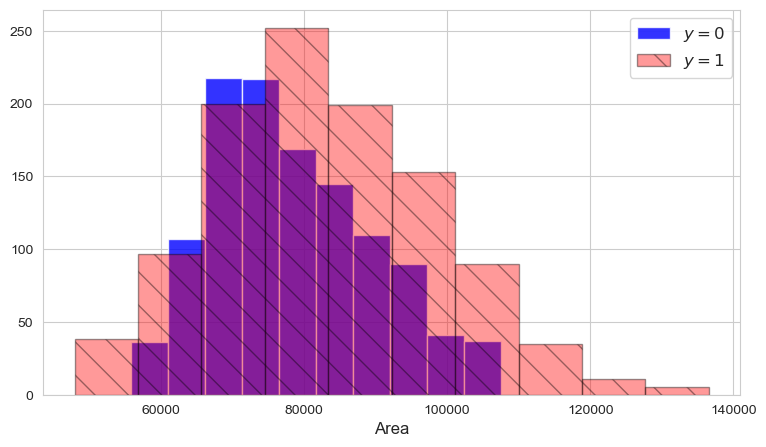

In [23]:
plt.figure(figsize=(9,5))


plt.hist(seeds_train.loc[seeds_train.y==0].Area.values,
            color='blue',
            alpha=.8,
            label="$y=0$")

plt.hist(seeds_train.loc[seeds_train.y==1].Area.values,
            color='red',
            alpha=.4,
            hatch = '\\',
            edgecolor='black',
            label="$y=1$")

plt.xlabel("Area", fontsize=12)
plt.legend(fontsize=12)

plt.show()

In this plot we can see that the two histograms are right on top of one another, indicating that the two classes of pumpkin seeds tend to have similar areas. This suggests that `Area` may not be a useful variable for discerning the seed class.

Use a `for` loop or some comparable method to produce similar histograms for each of the features. Write down the features that look like they may be useful for classification.

In [32]:
features = list(seeds.columns)
features.remove('y')
features.remove('Class')
features

['Area',
 'Perimeter',
 'Major_Axis_Length',
 'Minor_Axis_Length',
 'Convex_Area',
 'Equiv_Diameter',
 'Eccentricity',
 'Solidity',
 'Extent',
 'Roundness',
 'Aspect_Ration',
 'Compactness']

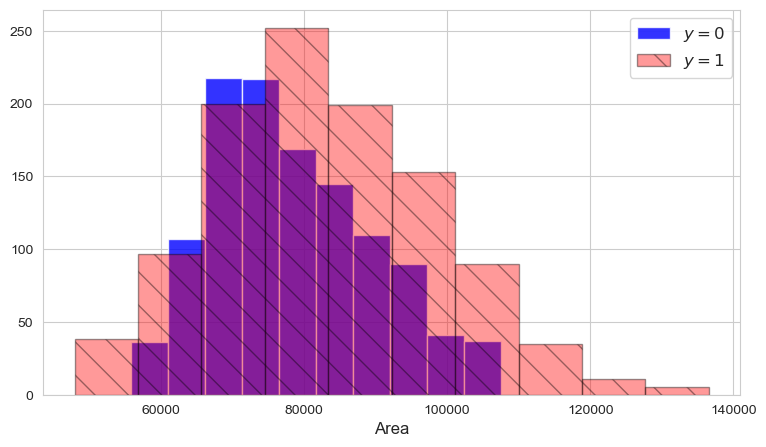

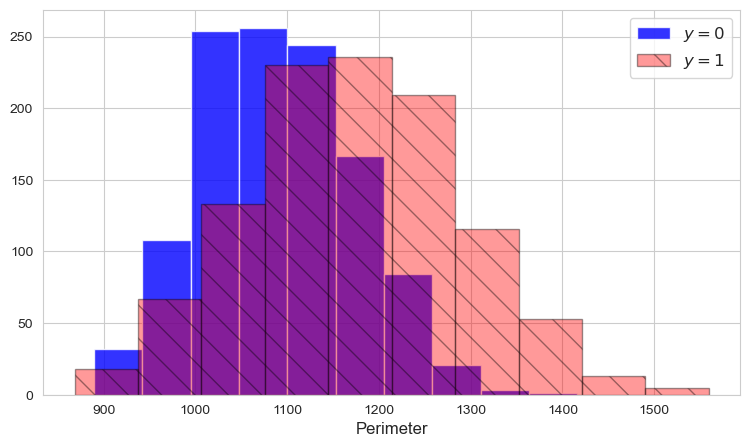

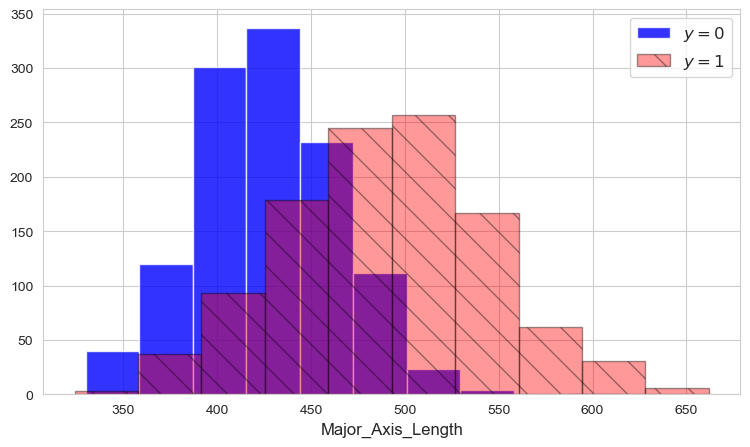

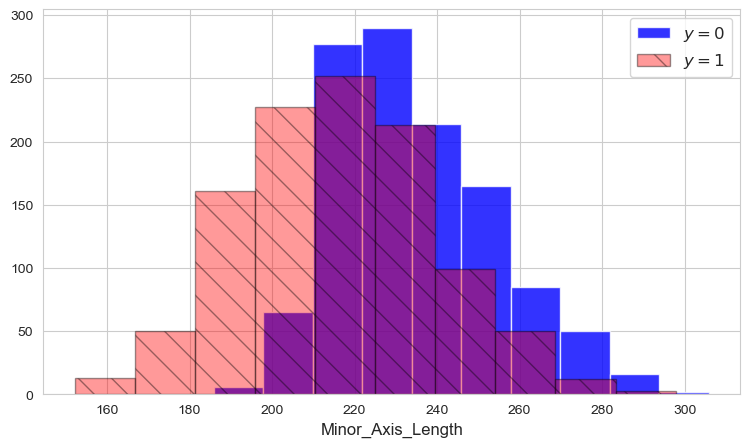

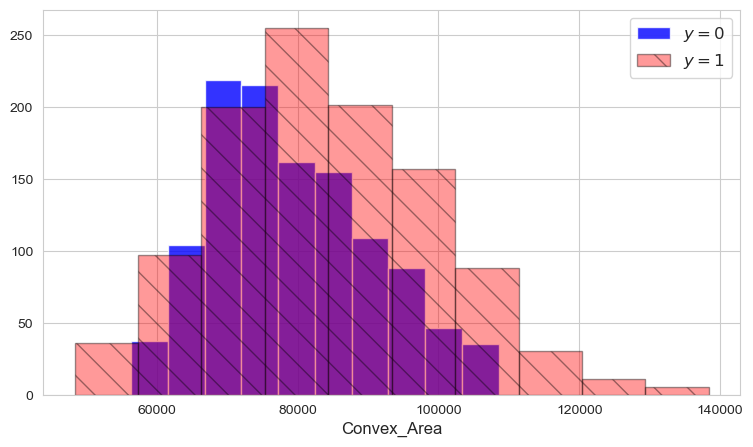

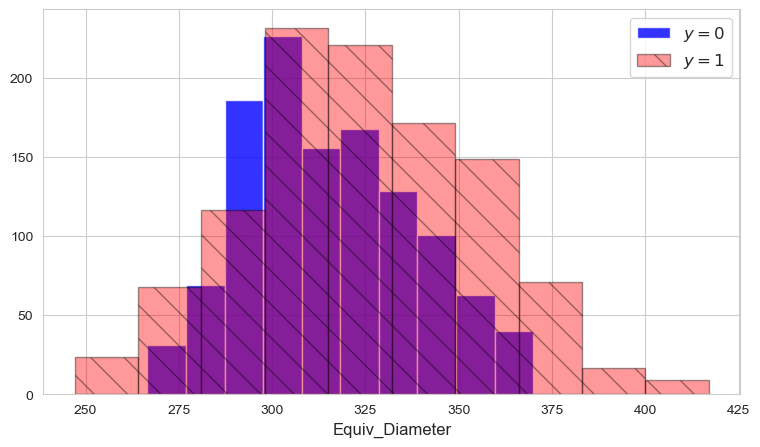

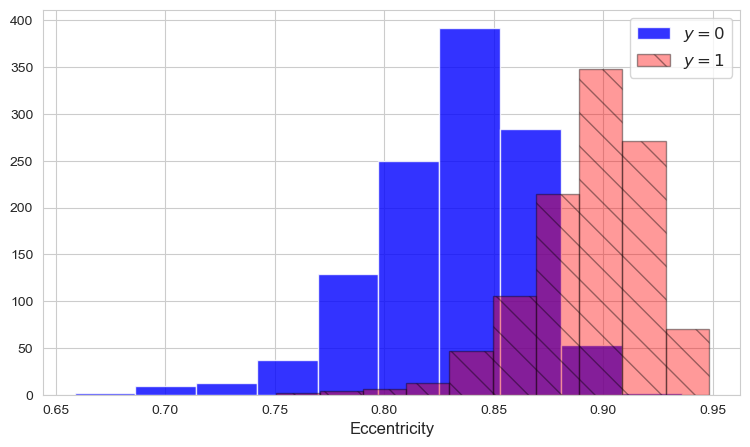

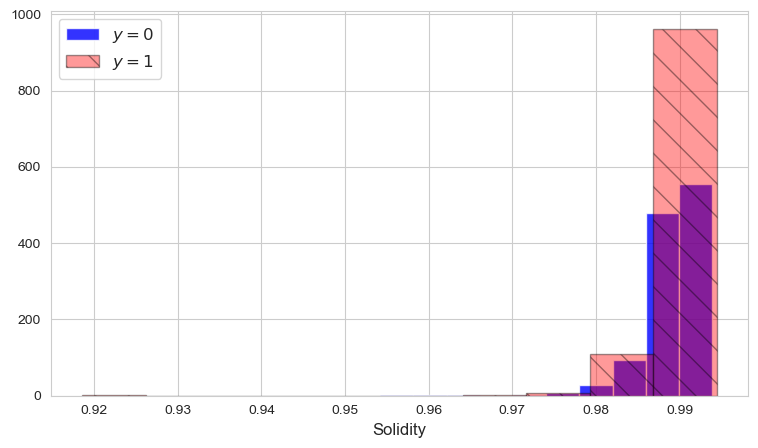

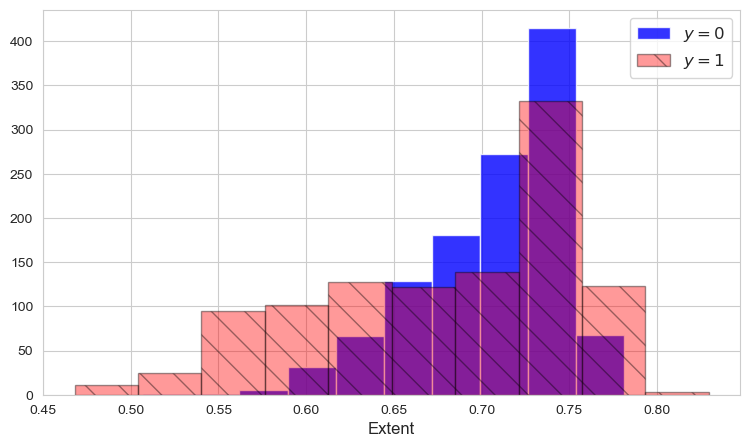

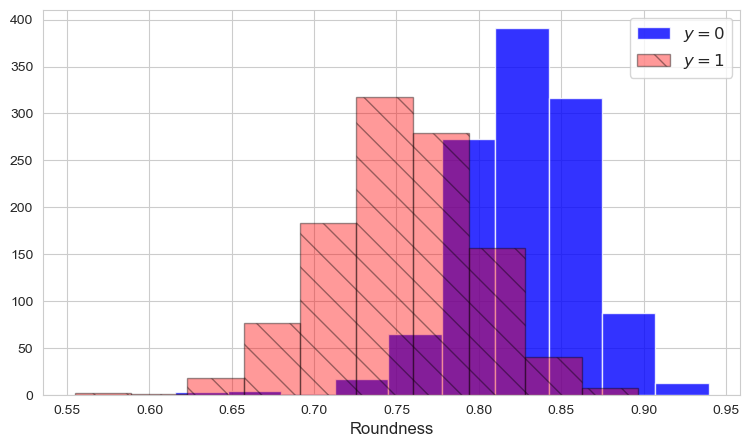

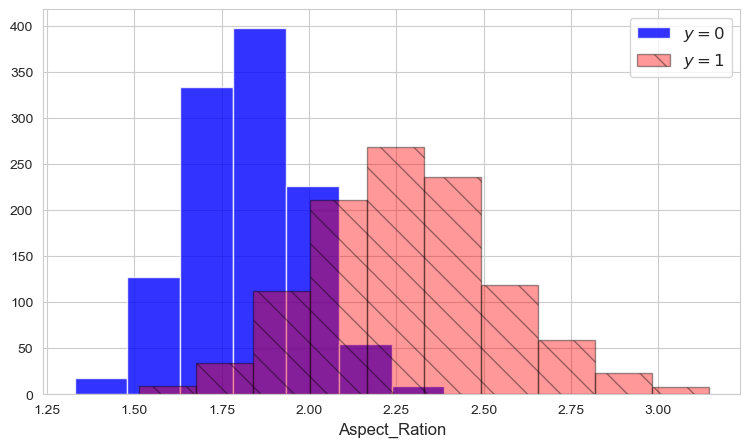

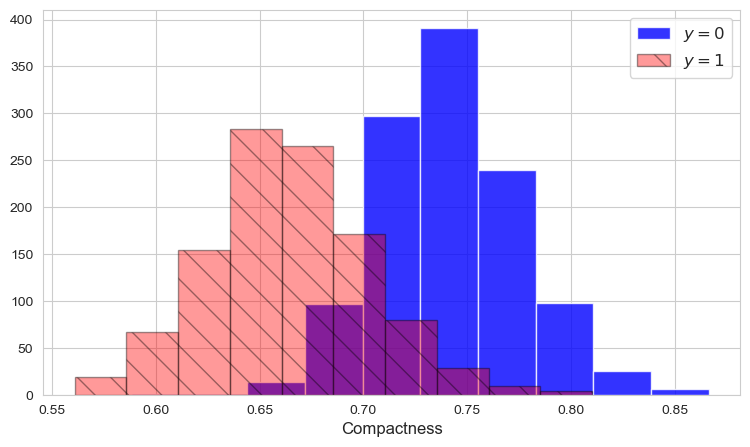

In [33]:
for feature in features:
    plt.figure(figsize=(9,5))


    plt.hist(seeds_train.loc[seeds_train.y==0][feature].values,
                color='blue',
                alpha=.8,
                label="$y=0$")

    plt.hist(seeds_train.loc[seeds_train.y==1][feature].values,
                color='red',
                alpha=.4,
                hatch = '\\',
                edgecolor='black',
                label="$y=1$")

    plt.xlabel(feature, fontsize=12)
    plt.legend(fontsize=12)

    plt.show()

In [ ]:
## code here



##### Keep track of your selected variables here

Compactness, Aspect_Ration, Roundness, Eccentricity, Major_Axis_Length

##### b.

Now try making a `seaborn` `pairplot` using the variables you identified in part <i>a.</i> as the arguments for `x_vars` and `y_vars`. Use `y` as the argument to `hue`. The main goal with this question is to see if you can identify any pairs of variables that seem to separate the two classes. You will use these plots later in the notebook.

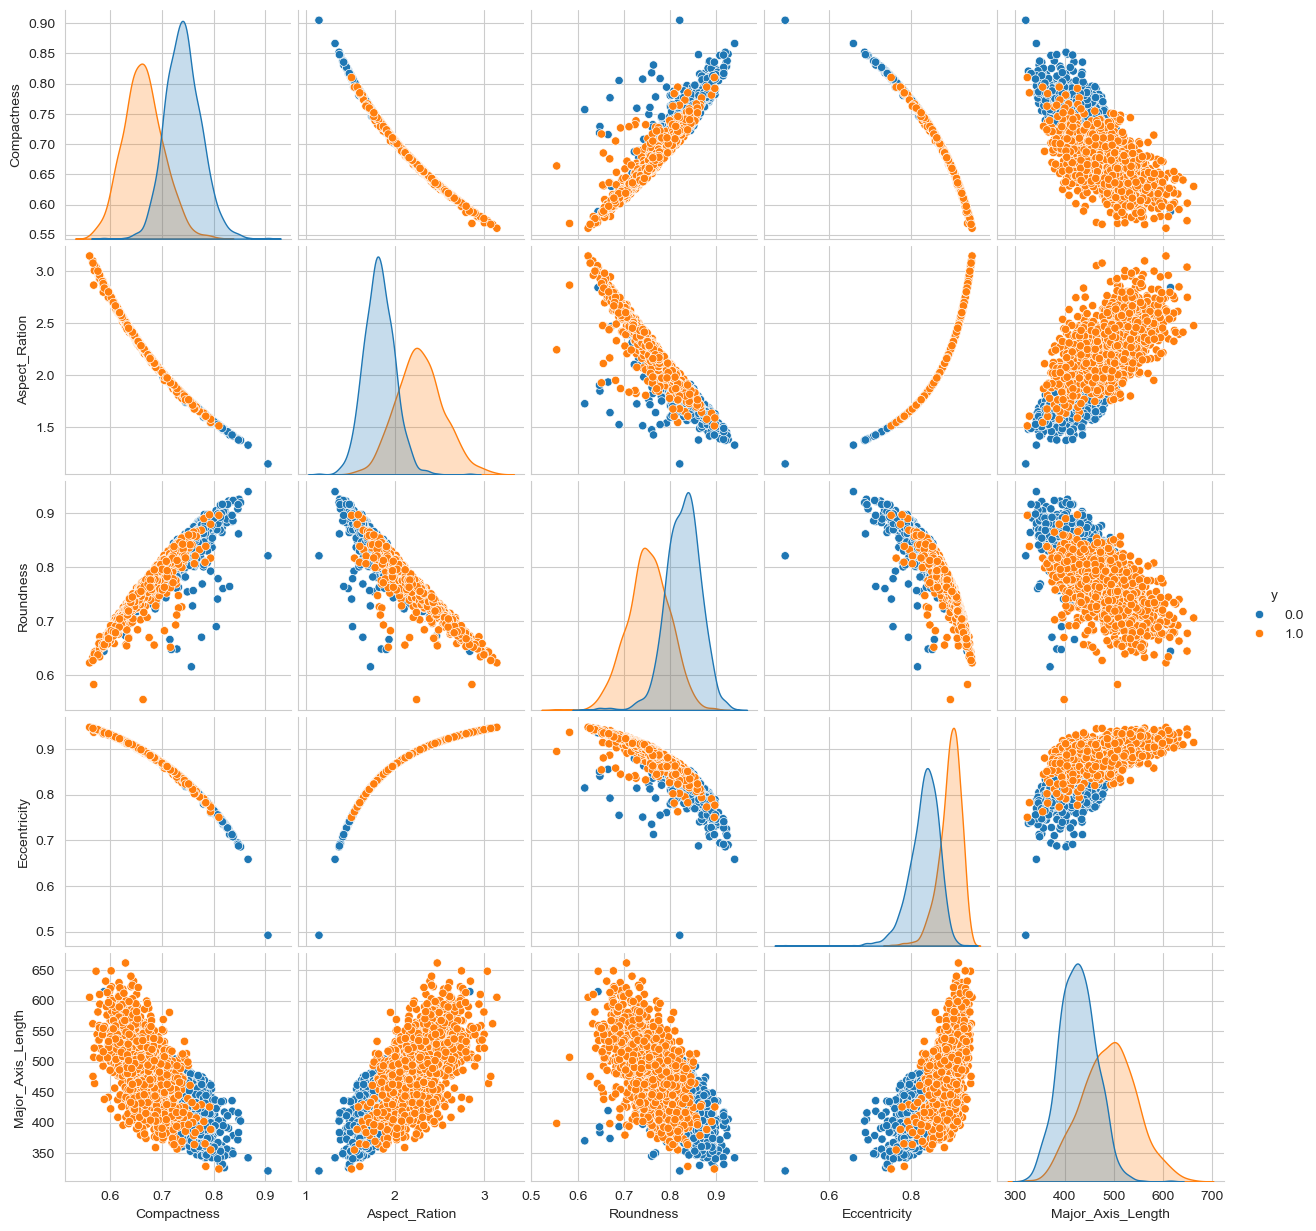

In [34]:
## Fill in the missing code
sns.pairplot(data = seeds,
                x_vars = ['Compactness', 'Aspect_Ration', 'Roundness', 'Eccentricity', 'Major_Axis_Length'],
                y_vars = ['Compactness', 'Aspect_Ration', 'Roundness', 'Eccentricity', 'Major_Axis_Length'],
                hue = 'y')

plt.show()

#### 5. Metric selection

In the remainder of this notebook you will make some initial models.

##### a.

Now that you have read about the data and looked at the split between the two classes what seems like a reasonable performance metric for this problem? Explain your answer.

##### Write here



##### b.

Recalling that `y=1` implies that the seed is of the Ürgüp Sivrisi class and `y=0` implies that the seed is of the Çerçevelik class, what do the following metrics measure in the context of this classification problem:
- recall
- precision
- false positive rate.

##### Write here

- recall:
- precision:
- false positive rate:

#### 6. Initial modeling attempts

In the remainder of this notebook you will make some initial models.

##### a.

Think of a baseline model for these data. Some common approaches are:
- A random coin flip whose probability for heads is the same as the probability of drawing the more present class,
- Classifying any observation as the majority class.

For whichever baseline you choose project the generalization accuracy of the baseline using the training data.

In [55]:
## code here
baseline=np.random.choice([0,1],size=len(seeds),p=[float(13/25),float(12/25)])


In [56]:
correct=0
incorrect=0
for i in range(len(seeds)):
    if float(baseline[i])==seeds.loc[i]['y']:
        correct+=1
    else:
        incorrect+=1


In [57]:
print(correct)
print(incorrect)



1230
1270


##### b.

Fill in the code below to perform 5-fold cross-validation in order to compare logistic regression models regressing `y` on each of the useful features you identified in your EDA above.

For this notebook run Logistic Regression without any L2 regularization.  Note that if we *did* regularize we should scale our regressors first, just like with linear regression.

In [58]:
## Import what you will need
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [59]:
## Make your kfold object
n_splits = 5

kfold = KFold(n_splits=n_splits)

In [73]:
## Fill in your list of features
features = ['Roundness','Eccentricity','Major_Axis_Length']

## Make your array of zeros to hold the accuracies
log_reg_accs = np.zeros((n_splits,len(features)))

## Loop through the cv splits
i = 0
for train_index, test_index in kfold.split(seeds_train):
    ## get the training and holdout sets
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## loop through your features
    j = 0
    for feature in features:
        ## Define the model
        log_reg = LogisticRegression()
        
        ## fit the model
        log_reg.fit(seeds_tt[[feature]],seeds_tt['y'])
        
        ## Make the prediction
        pred = log_reg.predict(seeds_ho[[feature]])
        
        ## Record the accuracy on the holdout set
        log_reg_accs[i,j] = accuracy_score(pred,seeds_ho['y'])
        
        j = j + 1
    i = i + 1

In [74]:
log_reg_accs

array([[0.84444444, 0.87777778, 0.78666667],
       [0.83555556, 0.86222222, 0.77777778],
       [0.84222222, 0.86666667, 0.72444444],
       [0.82      , 0.86888889, 0.76222222],
       [0.8       , 0.83333333, 0.75333333]])

##### c.

Compare these models to the logistic regression model that incorporates all of the features you identified with your histogram exploration.

In [82]:
features = list(seeds.columns)
features.remove('y')
features.remove('Class')
features

['Area',
 'Perimeter',
 'Major_Axis_Length',
 'Minor_Axis_Length',
 'Convex_Area',
 'Equiv_Diameter',
 'Eccentricity',
 'Solidity',
 'Extent',
 'Roundness',
 'Aspect_Ration',
 'Compactness']

In [87]:
i = 0

full_log_reg_acc=np.zeros(n_splits)

for train_index, test_index in kfold.split(seeds_train):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## Define the model, fit the model, then record the accuracies
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## loop through your features
    
    log_reg = LogisticRegression(penalty=None,max_iter=1000)
    
    ## fit the model
    log_reg.fit(seeds_tt[features],seeds_tt['y'])
    
    ## Make the prediction
    pred = log_reg.predict(seeds_ho[features])
    
    ## Record the accuracy on the holdout set
    full_log_reg_acc[i] = accuracy_score(pred,seeds_ho['y'])
    
    i = i + 1

In [88]:
## What is the avg. cv. accuracy?
full_log_reg_acc

array([0.88666667, 0.89111111, 0.88444444, 0.88222222, 0.87111111])

##### Make any notes you want here



##### d.

Fill in the code to find the optimal $k$ for a $k$ nearest neighbors model encorporating all of the features.

In [81]:
## Import the model classes.  Remember that we should always scale our features before using kNN.  So you should build pipelines to do this for you.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [98]:
## Fill in the range you want to try for k
ks = range(1,11)

## This will give you a list of all feature column names
all_features = seeds_train.columns[:-2]

## Make an array to hold the accuracies
k_all_accs = np.zeros((n_splits,len(ks)))

i = 0
for train_index, test_index in kfold.split(seeds_train):
    ## Get the train and holdout sets
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(seeds_tt[all_features],seeds_tt['y'])
        
        ## Make your prediction
        pred = knn.predict(seeds_ho[all_features])
        
        ## Record the accuracy on the holdout set
        k_all_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

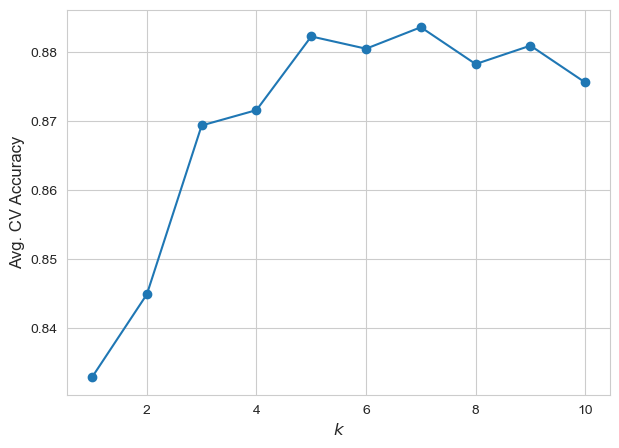

In [99]:
## Plots the accuracies as a function of k
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

##### e. 

Now see if you can improve the accuracy by using just the features you chose as a result of your histogram explorations. Did the best accuracy change? Did the optimal value of $k$ change?

In [101]:
select_features=['Roundness', 'Eccentricity', 'Major_Axis_Length']

In [102]:

## Fill in the range you want to try for k
ks = range(1,11)

## Make an array to hold the accuracies
k_select_accs = np.zeros((n_splits,len(ks)))

i = 0
for train_index, test_index in kfold.split(seeds_train):
    ## Get the train and holdout sets
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(seeds_tt[select_features],seeds_tt['y'])
        
        ## Make your prediction
        pred = knn.predict(seeds_ho[select_features])
        
        ## Record the accuracy on the holdout set
        k_select_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)
        
        j = j + 1
    i = i + 1


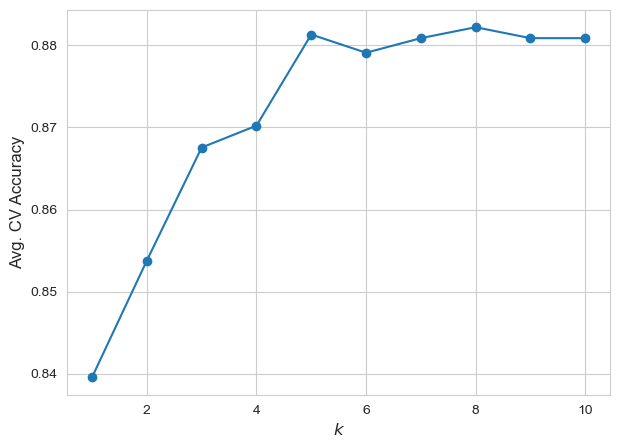

In [103]:
## This will plot the avg cv accuracies as a function of k
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_select_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

##### f.

As a final check see if you can improve the cross-validation accuracy further by only considering a pair of features from your `pairplot` exploration earlier.

In [104]:
final_features=['Roundness', 'Eccentricity']

In [105]:
## Fill in the range you want to try for k
ks = range(1,11)

k_final_accs = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(seeds_train):
    ## Get the train and holdout sets
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(seeds_tt[final_features],seeds_tt['y'])
        
        ## Make your prediction
        pred = knn.predict(seeds_ho[final_features])
        
        ## Record the accuracy on the holdout set
        k_final_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)
        
        j = j + 1
    i = i + 1


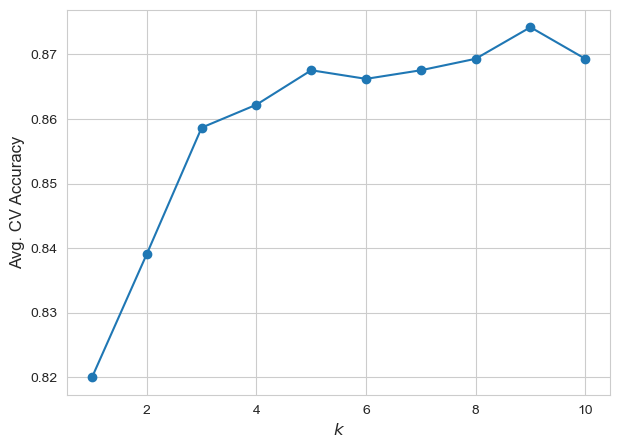

In [106]:
## This plots the accuracies as a function of k
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(k_final_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

##### 7. Summarizing the current results

Consider the best average CV accuracies of all of the models you built. Which one performed the best?

##### Write your answer here

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)